## B cells versus T cells
The data used in this notebook is lymphocyte data for one patient's B cells and T cells. We use this data to show the proteome variation between the cell types. Here, we note presence/absense changes and quantify fold changes using a T test.


First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
data_raw = load_data.load_max_quant()

data_raw

,Intensity 1_B_C10,Intensity 1_B_C11,Intensity 1_B_C12,Intensity 1_B_C13,Intensity 1_B_C9,Intensity 1_T_D10,Intensity 1_T_D11,Intensity 1_T_D12,Intensity 1_T_D13,Intensity 1_T_D9
Protein IDs,,,,,,,,,,
P0DPI2;A0A0B4J2D5,265300,248290,1878900,289210,0,0,0,0,0,654710
A0AVT1,0,0,440250,139370,0,0,303590,0,0,0
A6NHQ2,126410,0,0,89903,0,263160,0,0,110120,0
A6NI72;P14598;A8MVU1,1246500,1821600,3189500,2912100,1045700,0,0,0,0,0
P62308;A8MWD9,0,305850,0,0,0,0,0,0,0,372880
...,...,...,...,...,...,...,...,...,...,...
Q9Y5L4,0,0,237520,0,0,0,0,0,0,0
Q9Y5S9,766910,415980,458400,452850,862000,343680,495150,551340,766580,0
Q9Y5X3,682760,748590,1265600,543610,510570,0,0,0,0,336720


Before any analysis, we log normalize and median normalize across runs.

In [2]:
from numpy import nan
from numpy import log2
from statistics import median

data_log2 = log2(data_raw.replace(0,nan))
data_log2_normalized = data_log2.apply(lambda series: series-median(series.dropna()))

These are some methods that check if a value was measured or not and if the protein was measured in each type.

In [3]:
import data_utils

Here we record which proteins are only identified in one cell type. We'll set these aside for now, in the <code>data_in_one_type</code> dataframe. Note that <code>min_reps</code> is the minimum number of replicates required to list a protein as present in one type. This can be changed, i.e., <code>min_reps=5</code> to determine the proteins identified in all 5 replicates of a single type; do not set it to a number greater than the replicates run or no proteins will be returned.

In [4]:
present_only_in = data_log2_normalized.apply(data_utils.check_presence_absence, axis=1, min_reps=3).dropna()
print(present_only_in.value_counts())
data_in_one_type =data_log2_normalized.loc[present_only_in.index]
data_in_one_type['Type'] = present_only_in

T_cell    39
B_cell    38
dtype: int64


Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [5]:
indecies = data_log2_normalized.apply(data_utils.check_three_of_each_type, axis=1)
data = data_log2_normalized[indecies]

In [6]:
print ("Total groups identified:")
print(data_raw.shape[0])

print ("Proteins identified in at least 3 of each cell type:\t")
print (data.shape[0])

Total groups identified:
1230
Proteins identified in at least 3 of each cell type:	
699


Now we calulate p values using a ttest. 

In [7]:
#Call ttest function
tstats = data.apply(data_utils.ttest_wrapper, axis=1)

D:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Here we calculate fold change.

In [8]:
tstats['log2(B)-log2(T)'] = data.apply(data_utils.get_fold_changes, axis=1)

Fold change and p values allow us to create a volcano plot.

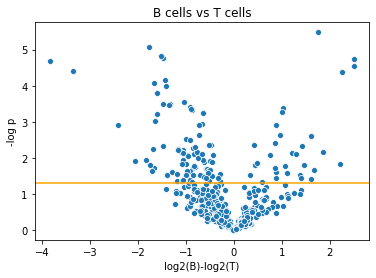

In [9]:
#graph volcano
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log10
tstats['-log p'] = -log10(tstats['pvalue'])

figure = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats)
figure.set_title("B cells vs T cells")
#plt.axvline(1, color ='orange')
#plt.axvline(-1, color ='orange')
plt.axhline(-log10(.05), color ='orange')
plt.show()

Next we will identify the altered proteins.

In [10]:
altered = tstats.apply(data_utils.is_altered, axis=1, change_factor=False).dropna()

These are significantly altered (p<0.01) without restricting by the magnitude of change:

In [11]:
altered.value_counts()

T cells    43
B cells    16
dtype: int64

In [12]:
print("Here are counts for other p and change cutoffs:")
print("P<0.05, >150% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.05,change_factor=1.5).value_counts()) #50% increase from either
print("\nP<0.05, >200% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.05,change_factor=2).value_counts()) #Double
print("\nP<0.05, >500% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.05,change_factor=5).value_counts()) #5 times larger

print("\nP<0.01, >150% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.01,change_factor=1.5).value_counts()) #50% increase from either
print("\nP<0.01, >200% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.01,change_factor=2).value_counts()) #Double
print("\nP<0.01, >500% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.01,change_factor=5).value_counts()) #5 times larger

Here are counts for other p and change cutoffs:
P<0.05, >150% of the other type
T cells    69
B cells    27
dtype: int64

P<0.05, >200% of the other type
T cells    38
B cells    19
dtype: int64

P<0.05, >500% of the other type
T cells    3
B cells    2
dtype: int64

P<0.01, >150% of the other type
T cells    40
B cells    15
dtype: int64

P<0.01, >200% of the other type
T cells    24
B cells    11
dtype: int64

P<0.01, >500% of the other type
T cells    3
B cells    2
dtype: int64


### Figure XXX: Differentially expressed proteins

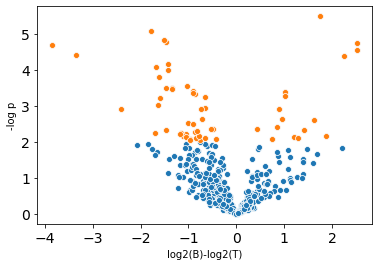

In [13]:
figure = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats)
figure2 = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats.loc[altered.index])
plt.rc('axes',labelsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title("B cells vs T cells", fontsize=20)

plt.savefig("data/BvsT.png", dpi=300)

This shows the differentially expressed proteins. Recall that this dataset is restricted to those expressed in at least three of each cell type.

The next step is to identify those proteins by name. Here we get the protein names from the fasta file, which remain the same regardless of which software the data was quantified using.

In [14]:
protein_names = load_data.load_fasta()

In [15]:
import pandas as pd
protein_names_by_group={}
for ID in data_raw.index:
    if ';' in ID:
        ids = ID.split(';')
        names=''
        for i in ids:
            if i in protein_names.index:
                names=names + protein_names[i] + ';'
        names = names[:-1]
        protein_names_by_group[ID] = names
    else:
        if ID in protein_names.index:
            protein_names_by_group[ID]=protein_names[ID]
protein_names_by_group = pd.Series(list(protein_names_by_group.values()), index=protein_names_by_group.keys())

Here we add the names to the <code>tstats</code> dataframe, which contains the fold changes for each protein. Then we can list the proteins that are altered. Optionally, use <code> head()</code> to display the first few or <code>to_csv</code> to write out to a file. We now split up the proteins heightened in B cells from those heightened in T cells.

In [16]:
tstats['Name']=protein_names_by_group
tstats['GeneID'] = tstats.Name.apply(lambda n: str(n).split('_HUMAN')[0])

altered_proteins = tstats.loc[altered.index].sort_values('log2(B)-log2(T)',
                        ascending=False)[['pvalue','log2(B)-log2(T)','Name','GeneID']]
higher_in_B_cells = altered_proteins.loc[altered_proteins['log2(B)-log2(T)'] >0]
higher_in_T_cells = altered_proteins.loc[altered_proteins['log2(B)-log2(T)'] <0]

#To write out to a file, use:
#altered_proteins.to_csv('data/filename.tsv', sep='\t')

Next we do the same for those only identified in one cell type.

In [17]:
data_in_one_type['Name'] = protein_names_by_group
data_in_one_type['GeneID']=data_in_one_type.Name.apply(lambda n: str(n).split('_HUMAN')[0])

B_cell_only_geneset = data_in_one_type[(data_in_one_type.Type=='B_cell')]
T_cell_only_geneset= data_in_one_type[(data_in_one_type.Type=='T_cell')]

### Proteins Higher in B Cells:

In [18]:
higher_in_B_cells.head()

,pvalue,log2(B)-log2(T),Name,GeneID
Protein IDs,,,,
P09960,0.000018,2.513640,LKHA4_HUMAN Leukotriene A-4 hydrolase,LKHA4
Q96KP4,0.000028,2.513483,CNDP2_HUMAN Cytosolic non-specific dipeptidase,CNDP2
P29350,0.000041,2.254605,PTN6_HUMAN Tyrosine-protein phosphatase non-re...,PTN6
P30040,0.006846,1.871703,ERP29_HUMAN Endoplasmic reticulum resident pro...,ERP29
P09874,0.000003,1.748271,PARP1_HUMAN Poly [ADP-ribose] polymerase 1,PARP1


### Proteins Only in B Cells:

In [19]:
B_cell_only_geneset[['Name', 'GeneID']].head()

,Name,GeneID
Protein IDs,,
A6NI72;P14598;A8MVU1,NCF1B_HUMAN Putative neutrophil cytosol factor...,NCF1B
O00151,PDLI1_HUMAN PDZ and LIM domain protein 1,PDLI1
O15400,TX7_HUMAN Syntaxin-7,TX7
O43169,CYB5B_HUMAN Cytochrome b5 type B,CYB5B
O43504,LTOR5_HUMAN Ragulator complex protein LAMTOR5,LTOR5


### Proteins higher or only in B cells by GeneID

In [20]:
B_cell_set = list(higher_in_B_cells.GeneID)+list(B_cell_only_geneset.GeneID)

### Proteins Higher in T Cells:

In [21]:
higher_in_T_cells.sort_values('log2(B)-log2(T)',ascending=True).head()

,pvalue,log2(B)-log2(T),Name,GeneID
Protein IDs,,,,
P26447,0.000021,-3.843883,10A4_HUMAN Protein S100-A4,10A4
P12814;Q08043;P35609,0.000040,-3.356164,ACTN1_HUMAN Alpha-actinin-1 ;ACTN3_HUMAN Alpha...,ACTN1
Q15149,0.001206,-2.411854,PLEC_HUMAN Plectin,PLEC
Q9UI08,0.000008,-1.775310,EVL_HUMAN Ena/VASP-like protein,EVL
P31949,0.005789,-1.695633,10AB_HUMAN Protein S100-A11,10AB


### Proteins Only in T Cells:

In [22]:
T_cell_only_geneset[['Name', 'GeneID']].head()

,Name,GeneID
Protein IDs,,
O00584,RNT2_HUMAN Ribonuclease T2,RNT2
O15117,FYB1_HUMAN FYN-binding protein 1,FYB1
O75915,PRAF3_HUMAN PRA1 family protein 3,PRAF3
P02545,LMNA_HUMAN Prelamin-A/C,LMNA
P06127,CD5_HUMAN T-cell surface glycoprotein CD5,CD5


### Proteins higher or only in T cells by GeneID

In [23]:
T_cell_set = list(higher_in_T_cells.GeneID)+list(T_cell_only_geneset.GeneID)